In [462]:
import pandas as pd
from prophet import Prophet

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

import pickle

---

# Contents

1. Load and clean data 
2. Model CurrentSpeed
3. Model AirTemp
4. Model CurrentDir
5. Using our forecasted predictions in our classification model 

---

**Lets look at the top three weather features in our classification model and see if we can use their forcasts to predict tacking.**

---

## 1. Load and clean data 

In [427]:
all_df = pd.read_csv('all_data.csv', index_col=0)

In [429]:
all_df['DateTime'] = pd.to_datetime(all_df['DateTime'])
all_df = all_df.sort_values(by='DateTime')
all_df = all_df.set_index('DateTime')
all_df = all_df.resample('10S').mean().dropna()
all_df = all_df.reset_index()
all_df = all_df[['CurrentSpeed', 'AirTemp', 'CurrentDir', 'Tacking', 'DateTime']]

---

Get data into right format for Prophet

In [71]:
def formatting(data, col):
    data = data.rename(columns={"DateTime": 'ds', col: "y"})
    return data[['ds', 'y']]

## 2. Model CurrentSpeed

In [598]:
df = formatting(all_df, 'CurrentSpeed')

In [599]:
m = Prophet(changepoint_prior_scale=0.01).fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [600]:
future = m.make_future_dataframe(periods=5, freq='H')
fcst = m.predict(future)

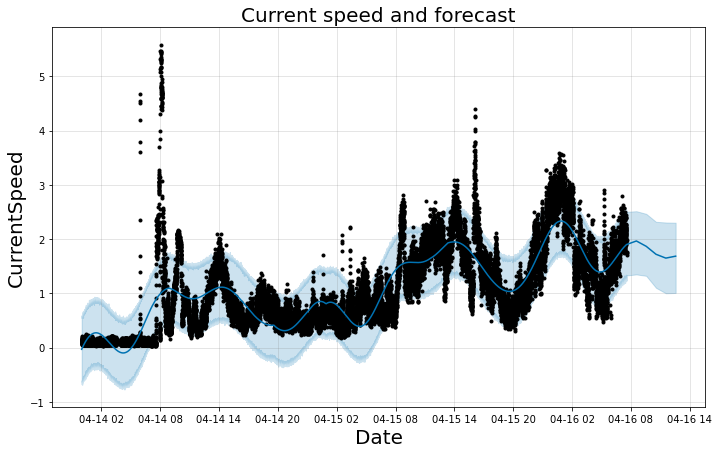

In [601]:
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title("Current speed and forecast", size=20)
ax.set_xlabel("Date", size=20)
ax.set_ylabel("CurrentSpeed", size=20);

Looks like its forecasting a reasonable prediction.

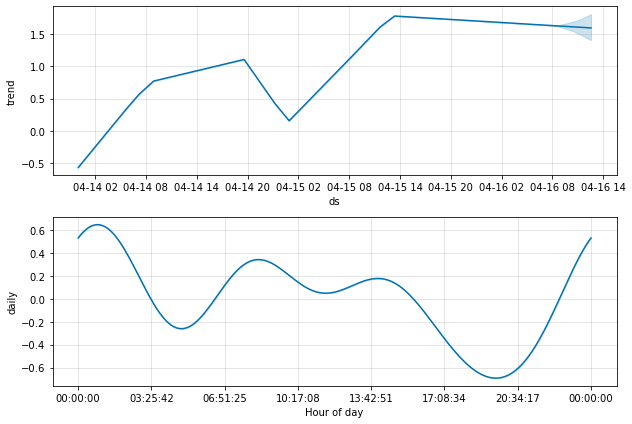

In [602]:
fig = m.plot_components(fcst)

In [603]:
def cross_val(model):
    return cross_validation(model, initial='30 hours', period='6 hours', horizon = '15 minutes', disable_tqdm=True)

In [604]:
df_cv = cross_val(m)

INFO:prophet:Making 5 forecasts with cutoffs between 2019-04-15 07:18:10 and 2019-04-16 07:18:10


In [605]:
df_p = performance_metrics(df_cv)

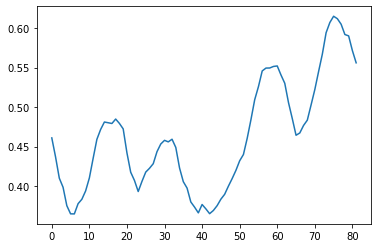

In [594]:
df_p.rmse.plot();

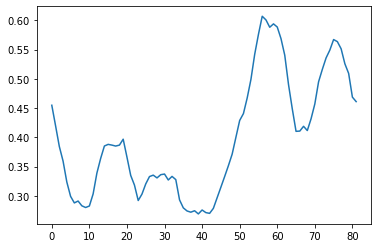

In [606]:
df_p.mape.plot();

The further away we get from the actual results, the larger the RMSE and MAPE. 

In [121]:
cs_predictions = df_cv.set_index('ds')['yhat']

---

## 3. Model AirTemp

In [574]:
df = formatting(all_df, 'AirTemp')

In [575]:
m = Prophet(changepoint_prior_scale=0.01).fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [577]:
future = m.make_future_dataframe(periods=5, freq='H')
fcst = m.predict(future)

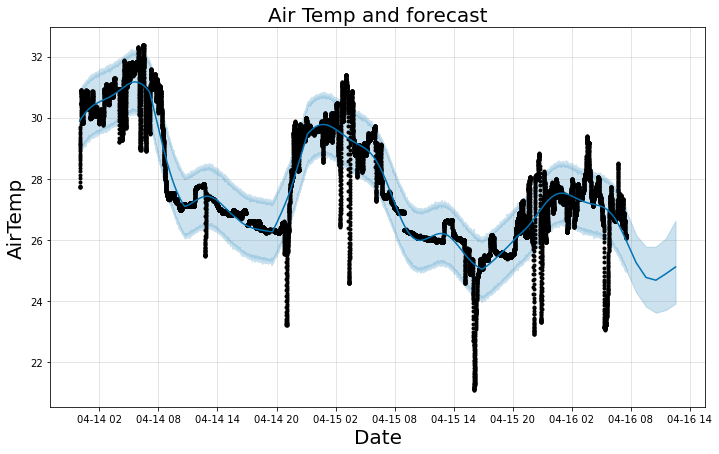

In [582]:
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title("Air Temp and forecast", size=20)
ax.set_xlabel("Date", size=20)
ax.set_ylabel("AirTemp", size=20);

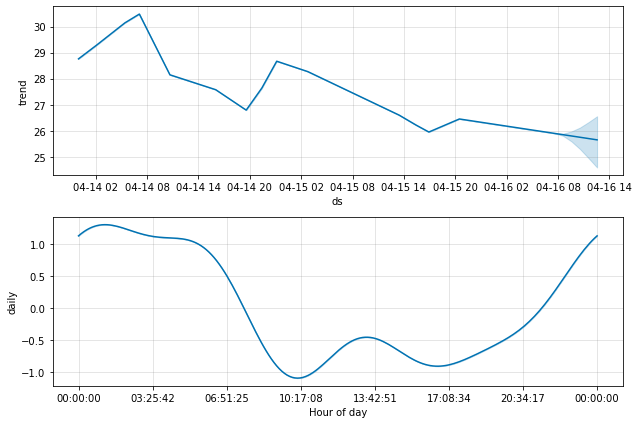

In [434]:
fig = m.plot_components(fcst)

In [435]:
df_cv_airtemp = cross_val(m)

INFO:prophet:Making 5 forecasts with cutoffs between 2019-04-15 07:18:10 and 2019-04-16 07:18:10


In [436]:
df_p_airtemp = performance_metrics(df_cv_airtemp)

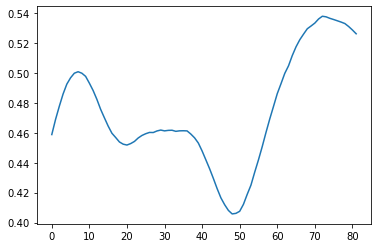

In [437]:
df_p_airtemp.rmse.plot();

In [451]:
airtemp_predictions = df_cv_airtemp.set_index('ds')['yhat']

## 4. Model CurrentDir

In [584]:
df = formatting(all_df, 'CurrentDir')

In [585]:
m = Prophet(changepoint_prior_scale=0.01).fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [588]:
future = m.make_future_dataframe(periods=5, freq='H')
fcst = m.predict(future)

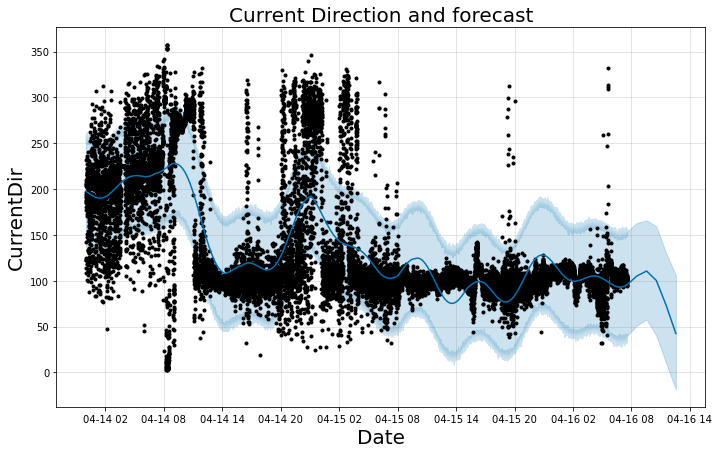

In [587]:
fig = m.plot(fcst)
ax = fig.gca()
ax.set_title("Current Direction and forecast", size=20)
ax.set_xlabel("Date", size=20)
ax.set_ylabel("CurrentDir", size=20);

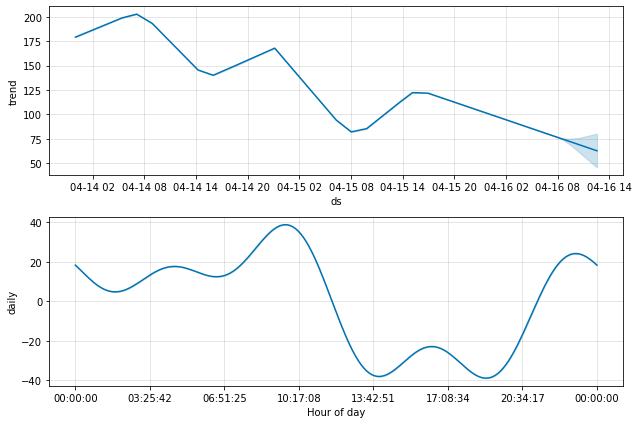

In [441]:
fig = m.plot_components(fcst)

In [443]:
df_cv_currentdir = cross_val(m)

INFO:prophet:Making 5 forecasts with cutoffs between 2019-04-15 07:18:10 and 2019-04-16 07:18:10


In [444]:
df_p_currentdir = performance_metrics(df_cv_currentdir)

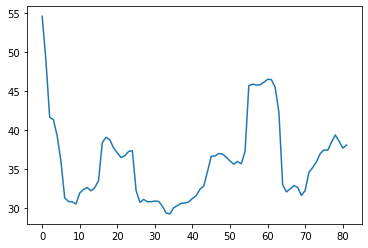

In [445]:
df_p_currentdir.rmse.plot();

In [456]:
currentdir_predictions = df_cv_currentdir.set_index('ds')['yhat']

## 5. Using our forecasted predictions in our classification model 

Can we predict tacking using all 3 of our weather forcast predictions? 

In [478]:
with open('rf_model_weather_top3', 'rb') as file:  
    rf = pickle.load(file)

In [523]:
predictions = pd.concat([cs_predictions, airtemp_predictions, currentdir_predictions], 
                      axis=1)
predictions.columns = ['cs_forcast', 'airtemp_forcast', 'cd_forcast']

We now need to get all the instances in time where tacking matches up to the predictions 

In [537]:
full_data = pd.concat([predictions[:250], all_df.set_index('DateTime')['Tacking']], axis=1, join='inner')

In [538]:
y = full_data.pop('Tacking')

In [539]:
scaler = StandardScaler()
full_data = pd.DataFrame(scaler.fit_transform(full_data), columns = full_data.columns, index=full_data.index)

In [541]:
y.value_counts(normalize=True)

0.0    0.72
1.0    0.28
Name: Tacking, dtype: float64

In [542]:
kf = KFold(shuffle=True) 
cross_val_score(rf, full_data, y, cv=kf)

array([1., 1., 1., 1., 1.])

Will look into this in the future.

In [543]:
print('CV score', cross_val_score(rf, full_data, y, cv=kf).mean())

CV score 1.0


In [545]:
def cm(model, X, y):
    
    preds = model.predict(X)
    classes = np.unique(y)
    
    fig, ax = plt.subplots()
    cm = confusion_matrix(y, preds, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)
    plt.show()

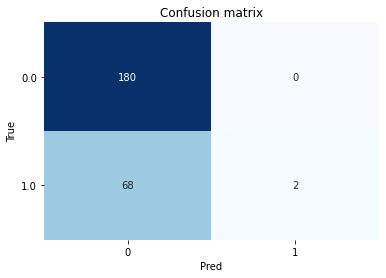

In [547]:
cm(rf, full_data, y)

In [548]:
predictions = rf.predict(full_data)
print(classification_report(y, predictions))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84       180
         1.0       1.00      0.03      0.06        70

    accuracy                           0.73       250
   macro avg       0.86      0.51      0.45       250
weighted avg       0.80      0.73      0.62       250



Given the forecasted values, the model is only able to class the no tacking class and is only able to get 2 instances of tacking correct. Would look to tune this in the future and also improve the forecast, reducing the RMSE and MAPE.

---